# 04 - Querying data tables with Pandas

This tutorial covers database-like features of the Pandas module.  It adds new objects: Dataframes, which are tables of data, and Series, which represent a single column or row.  They provide equivalent functions to the R programming language.  They can be used to analyse tables of data within Python using similar operations to those provided by Structured Query Language ([SQL](https://en.wikipedia.org/wiki/SQL)), which is used with relational database management systems.

Here, we will query the [Global Volcanism Program](http://www.volcano.si.edu/list_volcano_holocene.cfm)'s spreadsheet of Holocene volcanoes.  Many of the queries are based on the _Generate volcano trivia with this SQLite tutorial_ blog [post](http://www.volcano.si.edu/list_volcano_holocene.cfm). 

### Setting up

In [1]:
# Import modules
import datetime as dt
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Show plots within notebooks
%matplotlib inline

# Show module versions
print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
from matplotlib import __version__ as mplv
print('Matplotlib: {}'.format(mplv))

# Setup working directory
wdir = os.getcwd()  # Change this if required
data_dir = os.path.join(wdir, 'data_files')
os.chdir(wdir)

Python: 3.8.10 (default, Jun  2 2021, 10:49:15) 
[GCC 9.4.0]
Pandas: 1.3.0
Numpy: 1.21.0
Matplotlib: 3.4.2


### Import and check the data

In [2]:
# Pandas' read_csv command has lots of options for dealing with headers, footers etc.
gvp = pd.read_csv(os.path.join(data_dir, 'GVP_Volcano_List.csv'))

In [3]:
# Check the column names.
print(gvp.columns)

Index(['Volcano Number', 'Volcano Name', 'Country', 'Primary Volcano Type',
       'Last Known Eruption', 'Region', 'Subregion', 'Latitude', 'Longitude',
       'Elevation (m)', 'Dominant Rock Type', 'Tectonic Setting'],
      dtype='object')


In [4]:
# View the first 5 entries
gvp.head()

,Volcano Number,Volcano Name,Country,Primary Volcano Type,Last Known Eruption,Region,Subregion,Latitude,Longitude,Elevation (m),Dominant Rock Type,Tectonic Setting
0,210010,West Eifel Volcanic Field,Germany,Maar(s),8300 BCE,Mediterranean and W Asia,Western Europe,50.170,6.85,600.0,Foidite,Tensional Continental
1,210020,Chaîne des Puys,France,Lava dome(s),4040 BCE,Mediterranean and W Asia,Western Europe,45.775,2.97,1464.0,Basalt / Picro-Basalt,Tensional Continental
2,210030,Olot Volcanic Field,Spain,Pyroclastic cone(s),Unknown,Mediterranean and W Asia,Western Europe,42.170,2.53,893.0,Trachybasalt / Tephrite Basanite,Intermediate Continental
3,210040,Calatrava Volcanic Field,Spain,Pyroclastic cone(s),3600 BCE,Mediterranean and W Asia,Western Europe,38.870,-4.02,1117.0,Basalt / Picro-Basalt,Intermediate Continental
4,211001,Larderello,Italy,Explosion crater(s),1282 CE,Mediterranean and W Asia,Italy,43.250,10.87,500.0,No Data (checked),Compressional Continental


In [5]:
# View the last 2 entries
gvp.tail(2)

,Volcano Number,Volcano Name,Country,Primary Volcano Type,Last Known Eruption,Region,Subregion,Latitude,Longitude,Elevation (m),Dominant Rock Type,Tectonic Setting
1553,390130,Zavodovski,United Kingdom,Stratovolcano,1819 CE,Antarctica,Antarctica and South Sandwich Islands,-56.30,-27.57,551.0,Basalt / Picro-Basalt,Compressional Oceanic
1554,390140,Protector Shoal,United Kingdom,Submarine,1962 CE,Antarctica,Antarctica and South Sandwich Islands,-55.92,-28.08,-27.0,Rhyolite,Compressional Oceanic


### Accessing data

In [6]:
# Access individual columns as Pandas series using Python dictionary syntax.
gvp['Last Known Eruption'].tail()

1550    1911 CE
1551    Unknown
1552    Unknown
1553    1819 CE
1554    1962 CE
Name: Last Known Eruption, dtype: object

In [7]:
#  Get summary statistics for a column
print(gvp['Elevation (m)'].describe())

count    1508.000000
mean     1680.289788
std      1617.967809
min     -6000.000000
25%       727.250000
50%      1484.500000
75%      2375.250000
max      6887.000000
Name: Elevation (m), dtype: float64


In [8]:
# Data rows can be sliced based on their position
gvp[150:155]

,Volcano Number,Volcano Name,Country,Primary Volcano Type,Last Known Eruption,Region,Subregion,Latitude,Longitude,Elevation (m),Dominant Rock Type,Tectonic Setting
150,223004,Bunyaruguru,Uganda,Maar(s),Unknown,Africa and Red Sea,Africa (central),-0.200,30.080,1554.0,Foidite,Tensional Continental
151,223005,Katunga,Uganda,Tuff cone,Unknown,Africa and Red Sea,Africa (central),-0.471,30.191,1707.0,Foidite,Tensional Continental
152,223010,May-ya-moto,DR Congo,Hydrothermal field(fumarolic),Unknown,Africa and Red Sea,Africa (central),-0.930,29.330,950.0,No Data (checked),Tensional Continental
153,223020,Nyamuragira,DR Congo,Shield,2012 CE,Africa and Red Sea,Africa (central),-1.408,29.200,3058.0,Trachybasalt / Tephrite Basanite,Tensional Continental
154,223030,Nyiragongo,DR Congo,Stratovolcano,2013 CE,Africa and Red Sea,Africa (central),-1.520,29.250,3470.0,Foidite,Tensional Continental


In [9]:
# Using the index and the '.loc' command gives more meaningful access to the rows
gvp_names = gvp.set_index('Volcano Name')  # Make a copy with the Name column as the index
gvp_names.loc['Hekla']  # What information is there on Hekla?

Volcano Number                                372070
Country                                      Iceland
Primary Volcano Type                   Stratovolcano
Last Known Eruption                          2000 CE
Region                      Iceland and Arctic Ocean
Subregion                         Iceland (southern)
Latitude                                       63.98
Longitude                                      -19.7
Elevation (m)                                 1491.0
Dominant Rock Type      Andesite / Basaltic Andesite
Tectonic Setting                   Tensional Oceanic
Name: Hekla, dtype: object

In [10]:
# The '.loc' command accepts lists of rows and columns
gvp_names.loc[['Fuji', 'Etna'], 'Elevation (m)']  # Which is taller, Fuji or Etna?

Volcano Name
Fuji    3776.0
Etna    3330.0
Name: Elevation (m), dtype: float64

In [11]:
#  True/False (Boolean) indexing can be used to perform SQL-like 'WHERE' queries.
gvp_names.loc[gvp_names['Country'] == 'Iceland', ['Latitude', 'Longitude']]  # Where are Iceland's volcanoes?

,Latitude,Longitude
Volcano Name,,
Snaefellsjökull,64.800,-23.780
Helgrindur,64.870,-23.250
Ljósufjöll,64.870,-22.230
Reykjanes,63.880,-22.500
Krísuvík,63.930,-22.100
Brennisteinsfjöll,63.920,-21.830
Hengill,64.080,-21.320
Hrómundartindur,64.073,-21.202
Grímsnes,64.030,-20.870


### Manipulating data within the columns

In [12]:
# Add extra columns using dictionary assignment notation
gvp_names['Elevation (km)'] = gvp_names['Elevation (m)']/1000.0
gvp_names['Elevation (km)'].head()

Volcano Name
West Eifel Volcanic Field    0.600
Chaîne des Puys              1.464
Olot Volcanic Field          0.893
Calatrava Volcanic Field     1.117
Larderello                   0.500
Name: Elevation (km), dtype: float64

In [13]:
#  Operations on Series that contains text strings are done with the .str.command syntax
gvp_regions = gvp['Region']
print(gvp_regions.str.upper().head())  # Make text ALL CAPS
print()
print(gvp_regions.str.replace('and', '&').head())  # find and replace
print()
print(gvp_regions.str.contains('Asia').head())  # Search the text

0    MEDITERRANEAN AND W ASIA
1    MEDITERRANEAN AND W ASIA
2    MEDITERRANEAN AND W ASIA
3    MEDITERRANEAN AND W ASIA
4    MEDITERRANEAN AND W ASIA
Name: Region, dtype: object

0    Mediterranean & W Asia
1    Mediterranean & W Asia
2    Mediterranean & W Asia
3    Mediterranean & W Asia
4    Mediterranean & W Asia
Name: Region, dtype: object

0    True
1    True
2    True
3    True
4    True
Name: Region, dtype: bool


In [14]:
#  Use the .map method to apply a function to every entry in a column

# Define a function to convert text year into numerical value
def extract_year(year_string):
    """Drop the CE or BCE suffix from a date, e.g. '2015 CE', returning an integer.
    This allows sorting and indexing by the numerical value of the year."""
    if year_string == 'Unknown':
        return None
    
    year = year_string.split()[0]
    suffix = year_string.split()[1]
    
    if suffix == 'CE':
        return int(year)
    elif suffix == 'BCE':
        return -1 * int(year)
    else:
        raise ValueError('Cannot parse {} as eruption year.'.format(year_string))

# Add numerical date column and analyse
gvp['Last Known Eruption Year'] = gvp['Last Known Eruption'].map(extract_year)  # Applying functions to change values
gvp_years = gvp.dropna(subset=['Last Known Eruption Year']).set_index('Last Known Eruption Year').sort_index()
gvp_years.loc[1914:1919, ['Volcano Name', 'Country']]  # Volcanoes that began erupting during the First World War.

,Volcano Name,Country
Last Known Eruption Year,,
1914.0,Nakanoshima,Japan
1914.0,Goriaschaia Sopka,Russia
1914.0,Tanaga,United States
1915.0,Alayta,Ethiopia
1915.0,Southern EPR-Segment I,Undersea Features
1916.0,Smith Rock,Japan
1917.0,Tinguiririca,Chile
1917.0,Agrigan,United States
1917.0,Lassen Volcanic Center,United States


## Exercises

1. How many volcanoes are in Spain?
2. Which is further north, Cotopaxi or Kilimanjaro?

# Database-like analysis

Pandas dataframes can be manipulated in the same way as SQL-based databases.

In [15]:
#  Perform SQL-like SELECT and ORDER BY operations
gvp_names['Elevation (m)'].sort_values(ascending=False).head(10)

Volcano Name
Ojos del Salado, Nevados    6887.0
Llullaillaco                6739.0
Tipas                       6660.0
Incahuasi, Nevado de        6621.0
Cóndor, Cerro el            6532.0
Coropuna                    6377.0
Parinacota                  6348.0
Chimborazo                  6310.0
Pular                       6233.0
Solo, El                    6190.0
Name: Elevation (m), dtype: float64

In [16]:
#  Perform SQL-like GROUP BY operations
country_counts = gvp_names.groupby('Country').size()  # Count the number of volcanoes per country
country_counts.sort_values(ascending=False).head(10)  # Top 10 most volcanically active countries

Country
United States       184
Russia              154
Indonesia           142
Japan               114
Chile                78
Papua New Guinea     56
Ethiopia             54
Philippines          47
Mexico               39
Ecuador              34
dtype: int64

Text(0, 0.5, 'Mean elevation (m)')

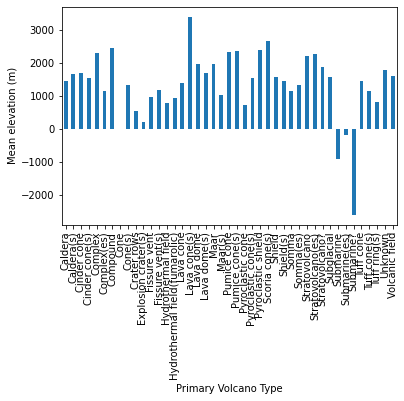

In [17]:
#  Plot results of groupby operations
type_sizes = gvp.groupby('Primary Volcano Type')['Elevation (m)'].mean()
type_sizes.plot(kind='bar')
plt.ylabel('Mean elevation (m)')

# Guess what: submarine volcanoes have the lowest mean elevations!

In [18]:
#  Use the pd.merge function to perform SQL-like JOINs of data tables
factbook = pd.read_csv(os.path.join(data_dir, 'factbook_extracts.csv'))
# CIA World Factbook data modified from https://www.google.com/fusiontables/DataSource?snapid=134490

gvp_factbook = pd.merge(gvp, factbook, left_on='Country', right_on='Country', how='inner')
print(gvp_factbook.columns)  # Note the extra columns

Index(['Volcano Number', 'Volcano Name', 'Country', 'Primary Volcano Type',
       'Last Known Eruption', 'Region', 'Subregion', 'Latitude', 'Longitude',
       'Elevation (m)', 'Dominant Rock Type', 'Tectonic Setting',
       'Last Known Eruption Year', 'Population', 'Life expectancy at birth',
       'Area', 'Natural hazards', 'GDP per capita ($ PPP)'],
      dtype='object')


In [19]:
#  Perform queries using data from both tables - what proportion of volcanoes are in the poorest countries?
LOW_GDP_CUTOFF = 5000  # By convention, use ALL_CAPS for constants
low_gdp_volcanoes = gvp_factbook.loc[gvp_factbook['GDP per capita ($ PPP)'] < LOW_GDP_CUTOFF]
msg = '{} of {} volcanoes are in countries with GDP per capita <${}.\n'.format(
    len(low_gdp_volcanoes),
    len(gvp),
    LOW_GDP_CUTOFF)
print(msg)

483 of 1555 volcanoes are in countries with GDP per capita <$5000.



In [20]:
#  What is the mean life expectancy in the GVP-defined regions?
gvp_factbook_regions = gvp_factbook.groupby('Region')
gvp_factbook_regions['Life expectancy at birth'].mean().sort_values(ascending=False)

Region
Japan, Taiwan, Marianas         81.847213
Canada and Western USA          81.230000
Hawaii and Pacific Ocean        80.980000
Iceland and Arctic Ocean        80.646774
Atlantic Ocean                  77.767692
Mediterranean and W Asia        76.542500
South America                   75.518757
West Indies                     75.127333
México and Central America      73.525478
Philippines and SE Asia         71.270000
New Zealand to Fiji             71.251250
Indonesia                       70.765448
Middle East and Indian Ocean    69.988545
Melanesia and Australia         67.376220
Kamchatka and Mainland Asia     66.795652
Kuril Islands                   66.030000
Africa and Red Sea              56.259370
Name: Life expectancy at birth, dtype: float64

### Exporting data

In [21]:
#  A Pandas Series (single column or row) can be exported as a list
iceland_volcanoes = gvp_names.loc[gvp_names['Country'] == 'Iceland', ['Latitude', 'Longitude']] 
volcano_names = iceland_volcanoes.index.tolist()
print(volcano_names)

['Snaefellsjökull', 'Helgrindur', 'Ljósufjöll', 'Reykjanes', 'Krísuvík', 'Brennisteinsfjöll', 'Hengill', 'Hrómundartindur', 'Grímsnes', 'Prestahnukur', 'Hveravellir', 'Hofsjökull', 'Vestmannaeyjar', 'Eyjafjallajökull', 'Katla', 'Tindfjallajökull', 'Torfajökull', 'Hekla', 'Grímsvötn', 'Bárdarbunga', 'Tungnafellsjökull', 'Kverkfjöll', 'Askja', 'Fremrinamur', 'Krafla', 'Theistareykjarbunga', 'Tjörnes Fracture Zone', 'Öraefajökull', 'Esjufjöll', 'Kolbeinsey Ridge']


In [22]:
#  Convert a column to a list
volcano_latitudes = iceland_volcanoes['Latitude'].tolist()
print(volcano_latitudes)

[64.8, 64.87, 64.87, 63.88, 63.93, 63.92, 64.08, 64.073, 64.03, 64.6, 64.75, 64.78, 63.43, 63.63, 63.63, 63.78, 63.92, 63.98, 64.42, 64.63, 64.73, 64.65, 65.03, 65.43, 65.73, 65.88, 66.3, 64.0, 64.27, 66.67]


In [23]:
#  Convert a row to a list
askja_lat_lon = iceland_volcanoes.loc['Askja'].tolist()
print(askja_lat_lon)

[65.03, -16.75]


In [24]:
#  A Pandas Dataframe (multiple columns) can be exported as a dictionary of lists
iceland_latlons = iceland_volcanoes[['Longitude', 'Latitude']]
iceland_latlons = iceland_latlons.to_dict('list')
print(iceland_latlons)

{'Longitude': [-23.78, -23.25, -22.23, -22.5, -22.1, -21.83, -21.32, -21.202, -20.87, -20.58, -19.98, -18.92, -20.28, -19.62, -19.05, -19.57, -19.17, -19.7, -17.33, -17.53, -17.92, -16.72, -16.75, -16.65, -16.78, -16.83, -17.1, -16.65, -16.65, -18.5], 'Latitude': [64.8, 64.87, 64.87, 63.88, 63.93, 63.92, 64.08, 64.073, 64.03, 64.6, 64.75, 64.78, 63.43, 63.63, 63.63, 63.78, 63.92, 63.98, 64.42, 64.63, 64.73, 64.65, 65.03, 65.43, 65.73, 65.88, 66.3, 64.0, 64.27, 66.67]}


In [25]:
#  Data can be exported to files with .to_csv, .to_excel, .to_latex commands.
#  There are options to control the format of dates and floating point numbers.
iceland_volcanoes = gvp_names.loc[gvp_names['Country'] == 'Iceland', ['Latitude', 'Longitude']]
iceland_volcanoes.to_csv('Icelandic_volcano_locations.csv', float_format='%.2f')
# Check the working directory to see the file

# Exercises

1. Export a csv file with a list of the names and locations of stratovolcanoes over 2500 m in South America.
2. What proportion of countries list volcanoes as a natural hazard?  (hint .str.contains('volcan.*')